In [1]:
# Import statements
import numpy as np
import pandas as pd
import sqlite3

In [2]:
# Connecting to sqlite 
conn = sqlite3.connect('pudl_subset.sqlite')

# Creating a cursor object using the cursor() method 
cursor = conn.cursor()

In [16]:
# Show all tables in database
tables_query = """SELECT name FROM sqlite_master  
                  WHERE type='table';"""
cursor.execute(tables_query)
table_list = cursor.fetchall()
print(table_list)

[('yearly_plant_generation',), ('monthly_generation_grouped',)]


### Database columns explained
Descriptions from: https://data.catalyst.coop/pudl/out_ferc1__yearly_all_plants

- report_year: "Four-digit year in which the data was reported."
- utility_id_ferc1: "PUDL-assigned utility ID, identifying a FERC1 utility. This is an auto- incremented ID and is not expected to be stable from year to year."
- utility_id_pudl: "A manually assigned PUDL utility ID. May not be stable over time."
- utility_name_ferc1: "Name of the responding utility, as it is reported in FERC Form 1. For human readability only."
- plant_id_pudl: "A manually assigned PUDL plant ID. May not be constant over time."
- plant_id_ferc1: "Algorithmically assigned PUDL FERC Plant ID. WARNING: NOT STABLE BETWEEN PUDL DB INITIALIZATIONS."
- plant_name_ferc1: "Name of the plant, as reported to FERC. This is a freeform string, not guaranteed to be consistent across references to the same plant."
- net_generation_mwh: "Net electricity generation for the specified period in megawatt-hours (MWh)."
- fuel_cost_per_mwh: "Derived from MCOE, a unit level value. Average fuel cost per MWh of heat content in nominal USD."
- plant_type: "Type of plant."
- fuel_type: "Type of fuel."
- net_load_mwh: "Net output for load (net generation - energy used for pumping) in megawatt- hours."

### Import database into Pandas dataframe
There is currently only one table in the database. This is how you import it into Pandas.

In [6]:
pudl_yearly_df = pd.read_sql_query("SELECT * FROM yearly_plant_generation", conn)

pudl_yearly_df.tail

<bound method NDFrame.tail of        report_year  utility_id_ferc1  utility_id_pudl_x  \
0             1995               185                 69   
1             1996               185                 69   
2             1998               185                 69   
3             1999               185                 69   
4             2001               185                 69   
...            ...               ...                ...   
79322         2023               300                287   
79323         2023               335                171   
79324         2023               393                 63   
79325         2023               393                 63   
79326         2023               395                308   

                                 utility_name_ferc1  plant_id_pudl  \
0                                   Cleco Power LLC              1   
1                                   Cleco Power LLC              1   
2                                   Cleco Power LLC

### Import monthly data into Pandas from database
This is likely the data we will use the most

In [7]:
# This doesn't currently work
pudl_monthly_df = pd.read_sql_query("SELECT * FROM monthly_generation_grouped", conn)
pudl_monthly_df.head()

,report_date,state,SUM(net_generation_mwh)
0,2001-01-01,None,3.284300e+04
1,2001-01-01,AK,3.282403e+05
2,2001-01-01,AL,8.843672e+06
3,2001-01-01,AR,3.886423e+06
4,2001-01-01,AZ,6.685144e+06


In [10]:
# Different values for type of plant
plant_types = pudl_yearly_df['plant_type'].unique()
print("Different plant types:", plant_types)

# Different values for type of fuel
fuel_types = pudl_yearly_df['fuel_type'].unique()
print("Different fuel types:", fuel_types)

Different plant types: ['steam' 'combustion_turbine' 'hydro' 'internal_combustion' None
 'combined_cycle' 'wind' 'nuclear' 'run_of_river' 'storage' 'geothermal'
 'photovoltaic' 'solar_thermal' 'run_of_river_with_storage' 'fuel_cell']
Different fuel types: [None 'hydro' 'wind' 'oil' 'solar' 'gas' 'coal' 'other' 'nuclear' 'waste']


In [12]:
# Function to get the schema of a table
def get_table_schema(table_name):
    schema_query = f"PRAGMA table_info({table_name});"
    cursor.execute(schema_query)
    schema = cursor.fetchall()
    return schema

# Get schema for each table
for table in table_list:
    table_name = table[0]
    schema = get_table_schema(table_name)
    print(f"Schema for table {table_name}:")
    for column in schema:
        print(f"  {column[1]} ({column[2]})")
    print("\n")

Schema for table yearly_plant_generation:
  report_year (BIGINT)
  utility_id_ferc1 (BIGINT)
  utility_id_pudl_x (BIGINT)
  utility_name_ferc1 (TEXT)
  plant_id_pudl (BIGINT)
  plant_id_ferc1 (FLOAT)
  plant_name_ferc1 (TEXT)
  net_generation_mwh (FLOAT)
  fuel_cost_per_mwh (FLOAT)
  plant_type (TEXT)
  fuel_type (TEXT)
  net_load_mwh (FLOAT)
  plant_id_eia (FLOAT)
  plant_name_eia (TEXT)
  city (TEXT)
  county (TEXT)
  latitude (FLOAT)
  longitude (FLOAT)
  state (TEXT)
  street_address (TEXT)
  zip_code (TEXT)
  utility_id_eia (FLOAT)
  utility_name_eia (TEXT)
  utility_id_pudl_y (FLOAT)


Schema for table monthly_generation_grouped:
  report_date (TEXT)
  state (TEXT)
  SUM(net_generation_mwh) (FLOAT)




In [23]:
# Query to select the first few rows of the yearly_plant_generation table
yearly_plant_generation = pd.read_sql_query("SELECT * FROM yearly_plant_generation", conn)

# Display the head of the dataframe
yearly_plant_generation.head()

,report_year,utility_id_ferc1,utility_id_pudl_x,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name_ferc1,net_generation_mwh,fuel_cost_per_mwh,plant_type,...,city,county,latitude,longitude,state,street_address,zip_code,utility_id_eia,utility_name_eia,utility_id_pudl_y
0,1995,185,69,Cleco Power LLC,1,1468.0,dolet hills,2246698.0,15.078641,steam,...,Mansfield,None,32.030556,-93.569168,LA,963 Power Plant Rd,71052,3265.0,Cleco Power LLC,69.0
1,1996,185,69,Cleco Power LLC,1,1468.0,dolet hills,2040348.0,16.029879,steam,...,Mansfield,None,32.030556,-93.569168,LA,963 Power Plant Rd,71052,3265.0,Cleco Power LLC,69.0
2,1998,185,69,Cleco Power LLC,1,1468.0,dolet hills,2172549.0,16.347895,steam,...,Mansfield,None,32.030556,-93.569168,LA,963 Power Plant Rd,71052,3265.0,Cleco Power LLC,69.0
3,1999,185,69,Cleco Power LLC,1,1468.0,dolet hills,1811051.0,19.006699,steam,...,Mansfield,None,32.030556,-93.569168,LA,963 Power Plant Rd,71052,3265.0,Cleco Power LLC,69.0
4,2001,185,69,Cleco Power LLC,1,1468.0,dolet hills,2268409.0,18.334631,steam,...,Mansfield,None,32.030556,-93.569168,LA,963 Power Plant Rd,71052,3265.0,Cleco Power LLC,69.0


In [28]:
# Query to select entries from yearly_plant_generation where state is VA
va_entries_query = "SELECT * FROM yearly_plant_generation WHERE state = 'VA'"

# Execute the query and store the result in a dataframe
va_entries_df = pd.read_sql_query(va_entries_query, conn)

# Display the dataframe
#va_entries_df

In [29]:
# Group the dataframe by report_year and calculate the sum of net_generation_mwh and net_load_mwh for each year
grouped_va_entries_df = va_entries_df.groupby('report_year')[['net_generation_mwh', 'net_load_mwh']].sum(numeric_only=True)

# Display the grouped dataframe
grouped_va_entries_df

,net_generation_mwh,net_load_mwh
report_year,,
1994,6.580792e+07,-7.761500e+05
1995,6.764227e+07,-8.775580e+05
1996,4.603431e+07,-7.741290e+05
1997,4.610374e+07,-9.034660e+05
1998,7.475789e+07,-6.252680e+05
1999,7.668811e+07,-8.210190e+05
2000,8.000889e+07,-1.372944e+06
2001,8.171340e+07,-1.423464e+06
2002,7.699501e+07,-1.437057e+06


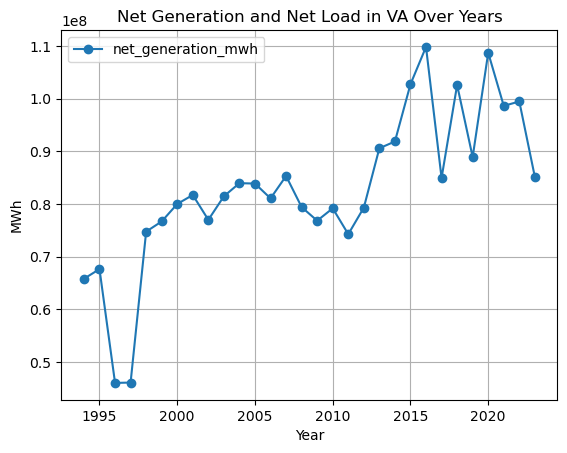

In [31]:
import matplotlib.pyplot as plt

# Plotting the data
grouped_va_entries_df.plot(y=['net_generation_mwh'], kind='line', marker='o')
plt.title('Net Generation and Net Load in VA Over Years')
plt.xlabel('Year')
plt.ylabel('MWh')
plt.grid(True)
plt.show()

In [ ]:
# Query to select entries from yearly_plant_generation where state is MA
ma_entries_query = "SELECT * FROM yearly_plant_generation WHERE state = 'MA'"

# Execute the query and store the result in a dataframe
ma_entries_df = pd.read_sql_query(ma_entries_query, conn)

# Group the dataframe by report_year and calculate the sum of net_generation_mwh and net_load_mwh for each year
grouped_ma_entries_df = ma_entries_df.groupby('report_year')[['net_generation_mwh', 'net_load_mwh']].sum(numeric_only=True)

# Plotting the data
grouped_ma_entries_df.plot(y=['net_generation_mwh'], kind='line', marker='o')
plt.title('Net Generation and Net Load in MA Over Years')
plt.xlabel('Year')
plt.ylabel('MWh')
plt.grid(True)
plt.show()